# Storing Small Files with dCache

## Introduction

This article describes a simple way to use <em>dCache</em> to efficiently store
and retrieve small files on tertiary storage systems. To avoid the overhead of
writing every file of a series by itself, we developed a set of scripts that
will add a layer of abstraction to transparently bundle the files and store them
together in an archive. This only requires minimal configuration on <em>dCache</em> 
and can be used with any dCache version 2.6 and higher.

### Requirements

The required configuration to use the scripts are a working <em>dCache</em> version 2.6.3 or higher installation. The pools should be big enough to store all the new files for at least one day and they must have the <tt>dcap</tt> libraries installed. 

The work station that packs the files needs to mount <em>Chimera</em> via <em>NFS4.1</em>.

## Installation

All files needed can be obtained via the git repository https://github.com/kschwank/SmallFiles


To install the Small Files capabilities do

### In the namespace

1. create subdirectories to store the archives, e.g, "archives".
1. on <tt>archives</tt> set <tt>AccessLatency</tt> to <tt>NEARLINE</tt> and <tt>RetentionPolicy</tt> to <tt>CUSTODIAL</tt>

### On the NFS4.1 door

1. add the file producing node to the <tt>/etc/dcache/exports</tt> with <tt>rw,no_root_squash</tt> access rights
1. add the packing node to the <tt>/etc/dcache/exports</tt> with <tt>rw,no_root_squash</tt> access rights


### On the pool nodes

1. install dcap libraries <pre>yum install dcap</pre>
1. edit <tt>hsm-internal.sh</tt> and set the following variables:
    1. <tt>LOG</tt> - default: <tt>LOG=/tmp/hsmio.log</tt>
    1. <tt>AWK</tt> - default: <tt>AWK=gawk</tt>
    1. <tt>LIBPDCAP</tt> - default: <tt>LIBPDCAP=/usr/lib64/libpdcap.so.1</tt>
    1. <tt>DCAP_DOOR</tt> - default: <tt>DCAP_DOOR="dcapdoor:22125"</tt>
1. set max storage handlers to 2 or higher (max 10) (<tt>st set max active 2</tt> in admin interface)
1. set max restore handlers to 2 or higher (<tt>rh set max active 2</tt> in admin interface)
1. configure the HSM <tt>dcache</tt> for your site on the pool in the admin interface
    1. <code>hsm set dcache -command=/usr/share/dcache/lib/hsm-internal.sh</code>
    1. <code>hsm set dcache -mongoUrl=mongohost/smallfiles</code>
    1. <code>save</code>
1. configure the HSM for the archive files

Finally the PoolManager has to be configured to allow staging and pool to pool transfers:

1. <code>cd PoolManager</code>
1. <code>pm set -p2p-allowed=yes</code>
1. <code>pm set -p2p-fortransfers=yes</code>
1. <code>pm set -stage-allowed=yes</code>
1. <code>save</code>

### On the file producing note

1. mount the NFS namespace to a local directory (e.g. <tt>/pnfs/4</tt>)
1. on the directories used to store the small files set the tags
    1. <tt>hsmInstance</tt> to <tt>dcache</tt>
    1. <tt>OSMTemplate</tt> to <tt>StoreName [data]</tt>, arbitrary but neccessary, e.g., <tt>archived</tt>
    1. <tt>sGroup</tt> to <tt>[sGroup]</tt>, arbitrary but neccessary, e.g., <tt>smallfiles</tt>

### On the packing node

1. mount the NFS namespace to a local directory (e.g. <tt>/pnfs/4</tt>)
1. install the packing scripts (<tt>fillmetadata.py, pack-files.py, writebfids.py</tt>) into your path

and make sure they are started automatically.

### On the database

Create an index on ctime on the files database

In [14]:
#> db.files.ensureIndex( { ctime: 1 }, { sparse: true } )
#> db.files.ensureIndex( { pnfsid: 1 }, { dropDups: true, unique: true } )

## Implementation

The implementation in its current form consists of 4 scripts, namely <tt>hsm-internal.sh</tt>, <tt>pack-files.py</tt>, <tt>fillmetadata.py</tt> and <tt>writebfids.py</tt>. The first script is called for every file and creates a minimal entry in a Mongo database. This entry is then used by the <tt>fillmetadata.py</tt> script to request more metadata for that file from chimera using the dot-files on the NFS4.1 mount. These enriched entries are then used by the <tt>pack-files.py</tt> script to create archives. For every archive another entry is created in a different collection that then used by the <tt>writebfids.py</tt> script to add the <tt>archiveUrl</tt> to the file entries. These are periodically checked by the hsm-scripts and removed after the <tt>archiveUrl</tt> is extracted to be written into chimera.

In [15]:
%%bash
cd ../msc
mscgen -T svg -o put.svg -i put.msc
mscgen -T svg -o check.svg -i check.msc
mscgen -T svg -o clear.svg -i clear.msc
mscgen -T svg -o pack.svg -i pack.msc
mscgen -T svg -o get.svg -i get.msc

bash: line 2: mscgen: command not found
bash: line 3: mscgen: command not found
bash: line 4: mscgen: command not found
bash: line 5: mscgen: command not found
bash: line 6: mscgen: command not found


When a fresh file arrives from the source the pool calls hsm-internal.sh which will create an entry in the Mongo database:

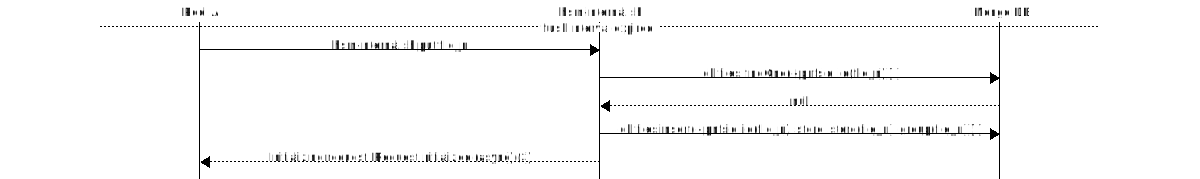

In [16]:
from IPython.display import SVG
SVG(filename='../msc/put.svg')

The file is then marked for a retry. Let's assume the packing script did not archive the file when the flush retry interval expires the next time. Then the retry is exactly like the first, except that this time the flag file already exists:

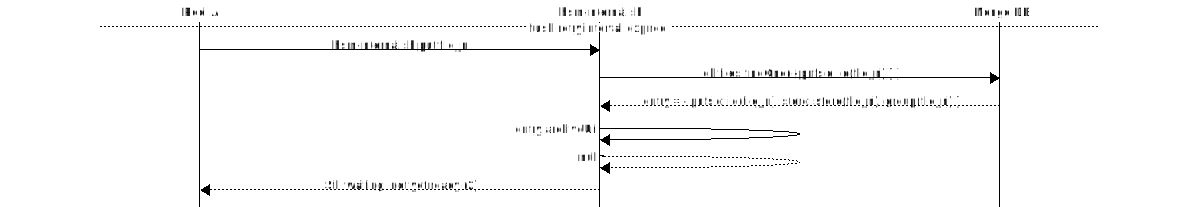

In [17]:
SVG(filename='../msc/check.svg')

The file is again marked for retry. Let's now assume that the packing script ran and collected the file. Then the retry will look like this:

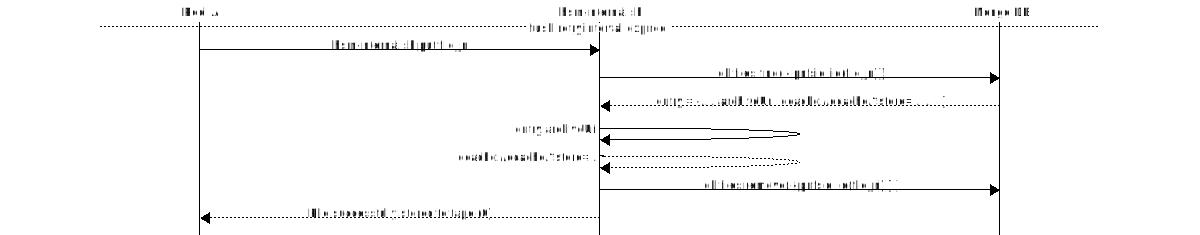

In [18]:
SVG(filename='../msc/clear.svg')

Packing the files works like this:

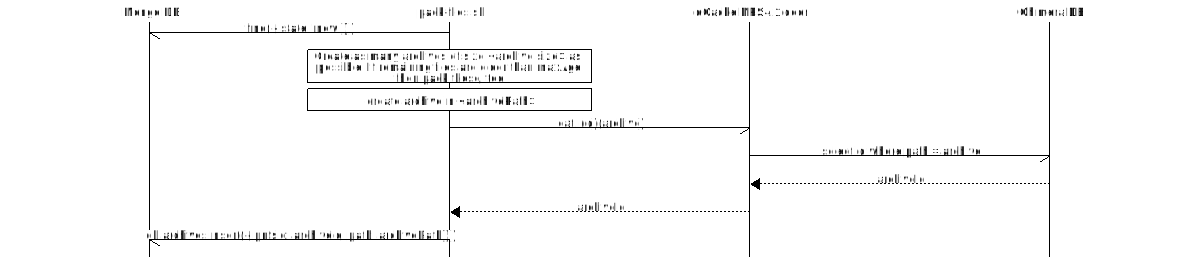

In [19]:
SVG(filename='../msc/pack.svg')

To get a previously archived file that was already removed from the pool the <tt>hsm-internal.sh</tt> script is called with the command <tt>get</tt>:

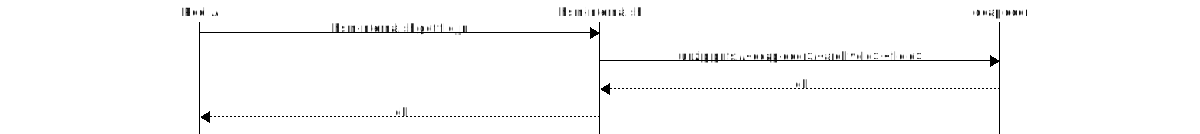

In [20]:
SVG(filename='../msc/get.svg')

## Scaling

If you have many files coming in at high rate, you may want to distribute the work load onto multiple instances, machines and databases. Distributing the work load will increase the speed, while introducing more requirements on the configuration and reduce flexibility.

If you are using multiple instances of the packing script, you have to make sure the sections inside their respective configuration do not have overlapping file patterns, otherwise files may be packed into multiple archives. The <tt>fillmetadata.sh</tt> and <tt>writebfids.sh</tt> scripts must only run as one instance per database.

The next step then is to use multiple databases, possibly on multiple servers to reduce the number of file entries in the database. This again will increase the speed of the scripts because of reduced search times on a single database. To archive this, the files have to be assigned to different <tt>hsmInstance</tt>s. For the hsmInstances then set different values for the <tt>mongoUrl</tt>.
If you use multiple databases, you have to run an additional instance of the <tt>fillmetadata.sh</tt> and <tt>writebfsid.sh</tt> scripts per database.

## Statistics

The statistics were created using the following machines:

- <tt>dcache-lab000</tt> as <em>dCache</em> head node with <em>NFS4.1</em> door
- <tt>dcache-lab001</tt> as pool node with <tt>st set max active 2</tt> (only in multiple pools runs)
- <tt>dcache-lab002</tt> as pool node with <tt>st set max active 2</tt>
- <tt>christian-vm01</tt> to inject small files and to periodically (1/min) run the <tt>pack-files.sh</tt>

The statistics are displayed using numpy, pandas and matplotlib:

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The files containing the statistics are included in the repository. We load them all here and combine them into one big <em>DataFrame</em> called <tt>allres</tt> for analysis. Note: We also add two more columns called <tt>fps</tt> for files per second and <tt>bps</tt> for bytes per second.

In [22]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
create1res = pd.io.parsers.read_csv('../resources/csv/create.csv', header=0)
create2res = pd.io.parsers.read_csv('../resources/csv/create2.csv', header=0)
createres = create2res
findres = pd.io.parsers.read_csv('../resources/csv/find2.csv',header=0)
lsres = pd.io.parsers.read_csv('../resources/csv/ls2.csv', header=0)
statres = pd.io.parsers.read_csv('../resources/csv/stat2.csv', header=0)
writeres = pd.io.parsers.read_csv('../resources/csv/write2.csv', header=0)
readres = pd.io.parsers.read_csv('../resources/csv/read2.csv', header=0)
pathofres = pd.io.parsers.read_csv('../resources/csv/pathof.csv', header=0)                              
tarres = pd.io.parsers.read_csv('../resources/csv/tar8.csv', header=0)
zipres = pd.io.parsers.read_csv('../resources/csv/zip8.csv', header=0)

results = { 'create' : createres, 
           'find' : findres, 
           'ls' : lsres, 
           'stat' : statres, 
           'write' : writeres, 
           'read' : readres, 
           'pathof' : pathofres, 
           'tar' : tarres, 
           'zip' : zipres }

for op in results.keys():
    df = results[op]
    df['op'] = op
    df['fps'] = df['file_count'] / df['total']
    df['bps'] = df['fps'] * df['file_size']
    results[op] = df
    
allres = pd.concat(results.values())
allres.describe

<bound method DataFrame.describe of     file_size  file_count   user   system    total     op           fps  \
0        1000        1000   0.46     3.98    21.15  write     47.281324   
1        1000        2000   1.12     9.15    56.12  write     35.637919   
2        1000        4000   2.29    19.88    74.14  write     53.951983   
3        1000       10000   4.84    53.56   192.83  write     51.859151   
4        1000       20000  11.55   130.44   409.75  write     48.810250   
5        1000      100000  46.90  1445.43  2955.29  write     33.837627   
6        2000        1000   0.38     3.94    17.96  write     55.679287   
7        2000        2000   0.85     8.10    35.99  write     55.570992   
8        2000        4000   2.17    19.69    73.98  write     54.068667   
9        2000       10000   5.22    52.01   200.19  write     49.952545   
10       2000       20000   8.12   114.24   404.14  write     49.487801   
11       2000      100000  43.05  1312.73  2826.76  write     35

In [24]:
allres.head(10)

,file_size,file_count,user,system,total,op,fps,bps
0,1000,1000,0.46,3.98,21.15,write,47.281324,47281.323877
1,1000,2000,1.12,9.15,56.12,write,35.637919,35637.918746
2,1000,4000,2.29,19.88,74.14,write,53.951983,53951.982735
3,1000,10000,4.84,53.56,192.83,write,51.859151,51859.150547
4,1000,20000,11.55,130.44,409.75,write,48.810250,48810.250153
5,1000,100000,46.90,1445.43,2955.29,write,33.837627,33837.626764
6,2000,1000,0.38,3.94,17.96,write,55.679287,111358.574610
7,2000,2000,0.85,8.10,35.99,write,55.570992,111141.983884
8,2000,4000,2.17,19.69,73.98,write,54.068667,108137.334415
9,2000,10000,5.22,52.01,200.19,write,49.952545,99905.090164


### Basic filesystem operations 

Copying files into <em>dCache</em>

In [25]:
createres = allres[allres.op == 'create']

The file rate is mostly independent of the number of files written into on directory as can be seen on the linear graphs:

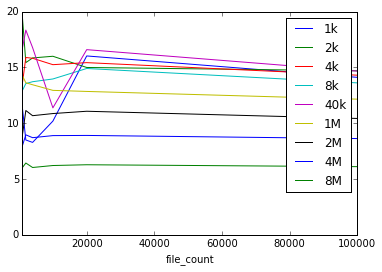

In [26]:
fig, ax = plt.subplots()

for key, grp in createres.groupby(['file_size']):
    grp[['fps']].plot(ax=ax, label=str(key), x=grp.file_count, ylim=[0,20])
    
plt.legend(('1k','2k','4k','8k','40k','1M','2M','4M','8M'), loc='best')
plt.show()

But highly depends on the size of the files:

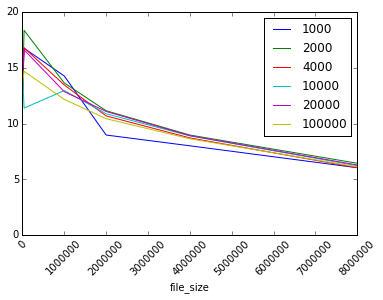

In [27]:
fig, ax = plt.subplots()

for key, grp in createres.groupby(['file_count']):
    grp[['fps']].plot(ax=ax, label=str(key), x=grp.file_size, ylim=[0,20], rot=45)
    
plt.legend(('1000','2000','4000','10000','20000','100000'), loc='best')
plt.show()

In [28]:
createres

,file_size,file_count,user,system,total,op,fps,bps
0,1000,1000,0.91,6.62,88.17,create,11.341726,11341.726211
1,1000,2000,1.79,13.45,235.18,create,8.504125,8504.124500
2,1000,4000,3.56,27.30,482.60,create,8.288438,8288.437630
3,1000,10000,9.55,70.88,980.70,create,10.196798,10196.798205
4,1000,20000,19.10,150.09,1247.27,create,16.035020,16035.020485
5,1000,100000,105.49,1124.04,7082.85,create,14.118610,14118.610446
6,2000,1000,0.85,6.50,51.36,create,19.470405,38940.809969
7,2000,2000,1.76,13.10,129.55,create,15.438055,30876.109610
8,2000,4000,3.64,26.48,252.26,create,15.856656,31713.311663
9,2000,10000,9.23,69.25,624.75,create,16.006403,32012.805122


The performance decreases with the amount of files written in sequence. The following graphs show two measurements, the first writing 3000 5MB files each into 9 directories. The second shows writing 7000 5MB files each into 5 directories.

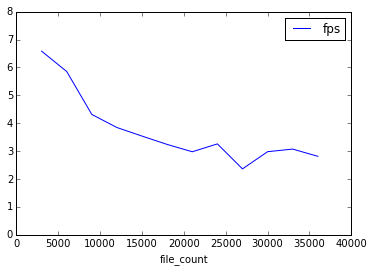

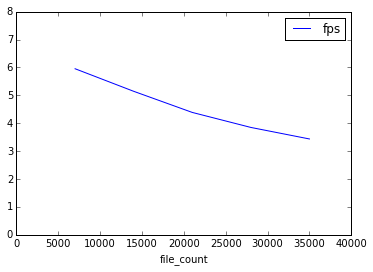

In [29]:
storeperf = pd.io.parsers.read_csv('../resources/csv/storeperf.csv', header=0)
storeperf['fps'] = 3000 / storeperf.total
storeperf[['fps']].plot(x=storeperf.file_count, xlim=(0,40000), ylim=(0,8))
storeperf2 = pd.io.parsers.read_csv('../resources/csv/storeperf2.csv', header=0)
storeperf2['fps'] = 7000 / storeperf2.total
storeperf2[['fps']].plot(x=storeperf2.file_count, xlim=(0,40000), ylim=(0,8))

### Getting directory contents usind ls and find

In [30]:
lsres = allres[allres.op == 'ls']
findres = allres[allres.op == 'find']

While the performance of <tt>ls</tt> and <tt>find</tt> does not differ significantly, the duration of both depends on the number of files in the directory:

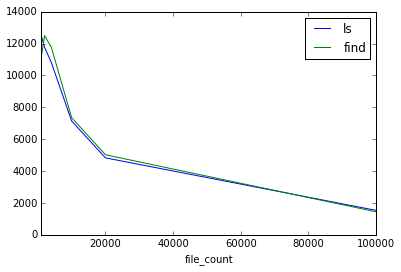

In [31]:
fig, ax = plt.subplots()

ls2M=lsres[lsres.file_size == 2000000]
find2M=findres[lsres.file_size == 2000000]
ls2M[['fps']].plot(ax=ax, label='ls', x=ls2M.file_count)
find2M[['fps']].plot(ax=ax, label='find', x=find2M.file_count)
plt.legend(('ls', 'find'), loc = 'best')

In [32]:
lsres

,file_size,file_count,user,system,total,op,fps,bps
0,1000,1000,0.00,0.00,0.16,ls,6250.000000,6.250000e+06
1,1000,2000,0.00,0.01,0.18,ls,11111.111111,1.111111e+07
2,1000,4000,0.00,0.02,0.33,ls,12121.212121,1.212121e+07
3,1000,10000,0.00,0.04,2.38,ls,4201.680672,4.201681e+06
4,1000,20000,0.00,0.10,5.15,ls,3883.495146,3.883495e+06
5,1000,100000,0.04,0.62,67.82,ls,1474.491301,1.474491e+06
6,2000,1000,0.00,0.00,0.10,ls,10000.000000,2.000000e+07
7,2000,2000,0.00,0.01,0.15,ls,13333.333333,2.666667e+07
8,2000,4000,0.00,0.02,0.35,ls,11428.571429,2.285714e+07
9,2000,10000,0.00,0.05,1.23,ls,8130.081301,1.626016e+07


In [33]:
findres

,file_size,file_count,user,system,total,op,fps,bps
0,1000,1000,0.00,0.00,0.40,find,2500.000000,2.500000e+06
1,1000,2000,0.00,0.01,0.20,find,10000.000000,1.000000e+07
2,1000,4000,0.00,0.02,0.41,find,9756.097561,9.756098e+06
3,1000,10000,0.00,0.05,1.43,find,6993.006993,6.993007e+06
4,1000,20000,0.01,0.11,5.80,find,3448.275862,3.448276e+06
5,1000,100000,0.07,0.67,67.83,find,1474.273920,1.474274e+06
6,2000,1000,0.00,0.00,0.09,find,11111.111111,2.222222e+07
7,2000,2000,0.00,0.01,0.19,find,10526.315789,2.105263e+07
8,2000,4000,0.00,0.02,0.41,find,9756.097561,1.951220e+07
9,2000,10000,0.00,0.06,1.43,find,6993.006993,1.398601e+07


### stat on files

<tt>stat</tt> depends on the number of files in the directory, but, of course, not on the size of the files:

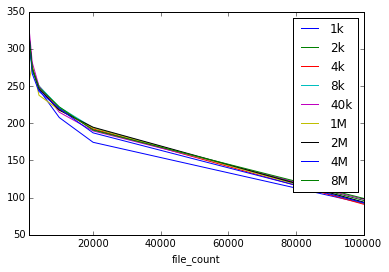

In [34]:
statres = allres[allres.op == 'stat']
#statres8M=statres[statres.file_size == 8000000]
#statres8M[['fps']].plot(x=statres8M.file_count)

fig, ax = plt.subplots()

for key, grp in statres.groupby(['file_size']):
    grp[['fps']].plot(ax=ax, label=str(key), x=grp.file_count)
    
plt.legend(('1k','2k','4k','8k','40k','1M','2M','4M','8M'), loc='best')
plt.show()

In [35]:
statres

,file_size,file_count,user,system,total,op,fps,bps
0,1000,1000,0.42,2.25,3.16,stat,316.455696,3.164557e+05
1,1000,2000,0.54,4.89,7.25,stat,275.862069,2.758621e+05
2,1000,4000,0.98,10.25,16.30,stat,245.398773,2.453988e+05
3,1000,10000,3.03,27.67,48.14,stat,207.727462,2.077275e+05
4,1000,20000,5.82,63.96,114.64,stat,174.459177,1.744592e+05
5,1000,100000,34.65,759.25,1081.69,stat,92.447929,9.244793e+04
6,2000,1000,0.29,2.37,3.11,stat,321.543408,6.430868e+05
7,2000,2000,0.49,4.96,7.37,stat,271.370421,5.427408e+05
8,2000,4000,1.15,10.09,16.00,stat,250.000000,5.000000e+05
9,2000,10000,2.86,27.90,45.34,stat,220.555801,4.411116e+05


### Writing into file's metadata level

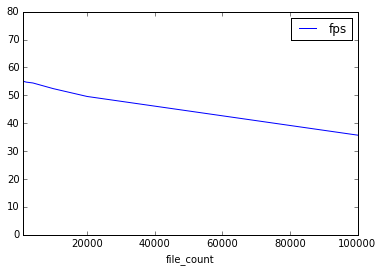

In [36]:
writeres = allres[allres.op == 'write']
writeres1M=writeres[writeres.file_size == 1000000]
writeres1M[['fps']].plot(x=writeres1M.file_count, ylim=(0,80))

In [37]:
writeres

,file_size,file_count,user,system,total,op,fps,bps
0,1000,1000,0.46,3.98,21.15,write,47.281324,4.728132e+04
1,1000,2000,1.12,9.15,56.12,write,35.637919,3.563792e+04
2,1000,4000,2.29,19.88,74.14,write,53.951983,5.395198e+04
3,1000,10000,4.84,53.56,192.83,write,51.859151,5.185915e+04
4,1000,20000,11.55,130.44,409.75,write,48.810250,4.881025e+04
5,1000,100000,46.90,1445.43,2955.29,write,33.837627,3.383763e+04
6,2000,1000,0.38,3.94,17.96,write,55.679287,1.113586e+05
7,2000,2000,0.85,8.10,35.99,write,55.570992,1.111420e+05
8,2000,4000,2.17,19.69,73.98,write,54.068667,1.081373e+05
9,2000,10000,5.22,52.01,200.19,write,49.952545,9.990509e+04


### Read the metadata level of all files in a directory

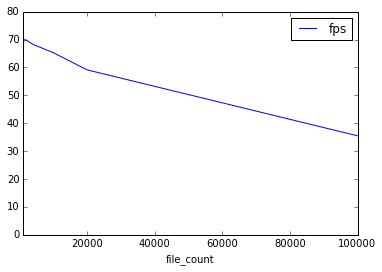

In [38]:
readres = allres[allres.op == 'read']
readres1M=readres[readres.file_size == 1000000]
readres1M[['fps']].plot(x=readres1M.file_count, ylim=(0,80))

In [39]:
readres

,file_size,file_count,user,system,total,op,fps,bps
0,1000,1000,0.68,6.36,14.25,read,70.175439,7.017544e+04
1,1000,2000,1.54,13.29,28.35,read,70.546737,7.054674e+04
2,1000,4000,3.12,27.52,59.20,read,67.567568,6.756757e+04
3,1000,10000,6.55,74.98,160.32,read,62.375250,6.237525e+04
4,1000,20000,15.49,183.17,348.24,read,57.431656,5.743166e+04
5,1000,100000,82.24,2066.45,2950.64,read,33.890952,3.389095e+04
6,2000,1000,0.60,5.92,13.59,read,73.583517,1.471670e+05
7,2000,2000,1.49,13.19,28.79,read,69.468565,1.389371e+05
8,2000,4000,3.08,27.31,57.18,read,69.954530,1.399091e+05
9,2000,10000,7.28,73.30,153.29,read,65.235828,1.304717e+05


### Querying the path by pnfsid using 'pathof'

Getting the path information of a file using "pathof" is independent of the file size, but it does depend on the number of files in the directory:

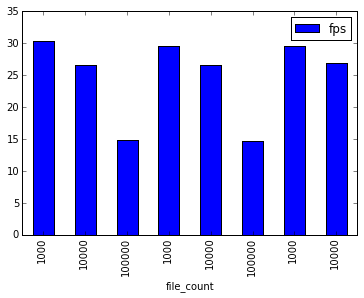

In [40]:
pathofres = allres[allres.op == 'pathof']
pathofres[['fps']].plot(x=pathofres.file_count, kind='bar')

In [41]:
pathofres

,file_size,file_count,user,system,total,op,fps,bps
0,1000,1000,1.67,9.72,33.01,pathof,30.293850,30293.850348
1,1000,10000,17.74,117.02,376.68,pathof,26.547733,26547.732824
2,1000,100000,259.83,4031.19,6734.91,pathof,14.848008,14848.008362
3,40000,1000,1.62,9.69,33.77,pathof,29.612082,1184483.269174
4,40000,10000,18.18,120.45,376.02,pathof,26.594330,1063773.203553
5,40000,100000,271.64,4023.86,6804.48,pathof,14.696200,587848.006020
6,1000000,1000,1.76,10.37,33.86,pathof,29.533373,29533372.711164
7,1000000,10000,17.38,117.07,371.56,pathof,26.913554,26913553.665626


## System performance

The following tables show durations for different configurations of file sizes, number of files and directories:

In [42]:
systemres = pd.io.parsers.read_csv('../resources/csv/system.csv', header=0)
systemres

,file_size,file_count,dir_count,pool_count,create,archive20,archive100,archive500,archive1000,archive2000,archive10000
0,1000,9000,9,1,540,4200,1740,NaN,1620,NaN,NaN
1,1000000,9000,1,9,1080,NaN,2040,NaN,1920,NaN,NaN
2,5000000,9000,1,9,1740,NaN,2400,NaN,2400,NaN,NaN
3,10000000,9000,1,9,2340,NaN,3420,NaN,NaN,NaN,NaN
4,5000000,90000,1,9,18720,NaN,NaN,NaN,NaN,22080,NaN
5,5000000,90000,1,9,20400,NaN,NaN,NaN,NaN,NaN,NaN
6,5000000,90000,9,1,19500,NaN,NaN,NaN,NaN,NaN,30000
7,1000,90000,9,1,19620,NaN,NaN,36000,NaN,NaN,NaN
8,5000000,10000,90,1,23400,NaN,NaN,NaN,24600,NaN,NaN
9,5000000,40000,2,1,16920,NaN,NaN,NaN,24600,NaN,NaN


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


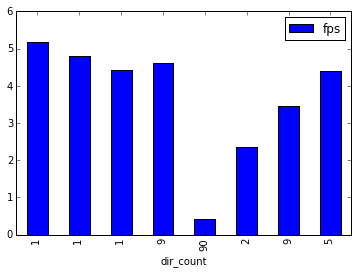

In [43]:
systemres5M = systemres[(systemres.file_size == 5000000)]
systemres5M['fps'] = systemres5M['file_count'] / systemres5M['create']
systemres5M[['fps']].plot(kind='bar', x=systemres5M.dir_count)

In [44]:
systemres5M

,file_size,file_count,dir_count,pool_count,create,archive20,archive100,archive500,archive1000,archive2000,archive10000,fps
2,5000000,9000,1,9,1740,NaN,2400,NaN,2400,NaN,NaN,5.172414
4,5000000,90000,1,9,18720,NaN,NaN,NaN,NaN,22080,NaN,4.807692
5,5000000,90000,1,9,20400,NaN,NaN,NaN,NaN,NaN,NaN,4.411765
6,5000000,90000,9,1,19500,NaN,NaN,NaN,NaN,NaN,30000,4.615385
8,5000000,10000,90,1,23400,NaN,NaN,NaN,24600,NaN,NaN,0.427350
9,5000000,40000,2,1,16920,NaN,NaN,NaN,24600,NaN,NaN,2.364066
11,5000000,36000,9,2,10459,NaN,NaN,NaN,NaN,15720,NaN,3.442012
12,5000000,35000,5,2,7984,NaN,NaN,NaN,NaN,16200,NaN,4.383768


# Scripts

## hsm-internal.sh

<tt>hsm-internal.sh</tt> is being called for each file of with <tt>osm=dcache</tt> with the command <tt>put</tt>. It is also used with the command <tt>get</tt> to retrieve the file again from the archive.

In [45]:
!cat ../../skel/usr/share/dcache/lib/hsm-internal.sh

#!/bin/sh
#
# $Id: hsmcpV4.sh,v 1.1 2006-05-31 14:08:15 tigran Exp $
#
#set -x
#
#
#    dCache configuration
#
#   hsm set dcache -command=<fullPathToThisScript> # e.g., /usr/share/dcache/lib/hsm-internal.sh
#   hsm set dcache -mongoUrl=<urlOfMongoDb> # e.g., server.example.org/database
#
#########################################################
#
#   prerequisits
#
LOG=/var/log/dcache/hsm-internal.log
DEVTTY=$LOG
AWK=gawk
#
#
#########################################################
#
#  some help functions
#
usage() {
   echo "Usage : put|get <pnfsId> <filePath> [-si=<storageInfo>] [-key[=value] ...]" | tee -a $LOG >&2
}
report() {
   echo "`date +"%D-%T"` ($$) $pnfsid $1" | tee -a $LOG >&2
}
problem() {
   echo "($$) $2 ($1)" | tee -a $LOG >&2
   exit $1
}
errorReport() {
   echo "($$) $1" | tee -a ${LOG} >&2
   return 0
}
#
#
#########################################################
#
#  Resolve pnfsID into canonical file name.
#  Argument : pnfsID
#  Returns  : filename
#
resolveP

## pack-files.py

The <tt>pack-files.py</tt> scripts collect the files the <tt>hsm-internal.sh</tt> creates entries for.

In [46]:
!cat ../../skel/usr/local/bin/pack-files.py

#!/usr/bin/env python

import os
import sys
import time
from datetime import datetime, timedelta
import hashlib
import signal
import re
import ConfigParser as parser
from tempfile import NamedTemporaryFile
from zipfile import ZipFile
from pymongo import MongoClient, errors, ASCENDING, DESCENDING
from pwd import getpwnam
import logging

running = True

def sigint_handler(signum, frame):
    global running
    logging.info("Caught signal %d." % signum)
    print("Caught signal %d." % signum)
    running = False

scriptId = 'pack'
archiveUser = 'root'
archiveMode = '0644'
mongoUri = "mongodb://localhost/"
mongoDb  = "smallfiles"
mountPoint = ""
dataRoot = ""

class Container:

    def __init__(self, targetdir):
        tmpfile = NamedTemporaryFile(suffix = '.darc', dir=targetdir, delete=False)
        self.arcfile = ZipFile(tmpfile.name, mode = 'w', allowZip64 = True)
        global archiveUser
        global archiveMode
        self.archiveUid = getpwnam(archiveUser).pw_uid
        self.

## fillmetadata.py

In [47]:
!cat ../../skel/usr/local/bin/fillmetadata.py

#!/usr/bin/env python

import os
import sys
import time
import signal
import ConfigParser as parser
from pymongo import MongoClient, Connection, errors
import logging

running = True

def sigint_handler(signum, frame):
    global running
    logging.info("Caught signal %d." % signum)
    print("Caught signal %d.'" % signum)
    running = False

mongoUri = "mongodb://localhost/"
mongoDb  = "smallfiles"
mountPoint = ""
dataRoot = ""

def dotfile(filepath, tag):
    with open(os.path.join(os.path.dirname(filepath), ".(%s)(%s)" % (tag, os.path.basename(filepath))), mode='r') as dotfile:
       result = dotfile.readline().strip()
    return result

def main(configfile = '/etc/dcache/container.conf'):
    global running

    try:
        while running:
            configuration = parser.RawConfigParser(defaults = { 'scriptId': 'pack', 'mongoUri': 'mongodb://localhost/', 'mongoDb': 'smallfiles', 'loopDelay': 5, 'logLevel': 'ERROR' })
            configuration.read(configfile)

            glo

## writebfids.py

In [48]:
!cat ../../skel/usr/local/bin/writebfids.py

#!/usr/bin/env python

import os
import sys
import time
import errno
import signal
from zipfile import ZipFile, BadZipfile
from pymongo import MongoClient, errors
import ConfigParser as parser
import logging

running = True

def sigint_handler(signum, frame):
    global running
    print("Caught signal %d." % signum)
    running = False

def main(configfile = '/etc/dcache/container.conf'):
    global running

    try:
        while running:
            configuration = parser.RawConfigParser(defaults = { 'scriptId': 'pack',  'mongoUri': 'mongodb://localhost/', 'mongoDb': 'smallfiles', 'loopDelay': 5, 'logLevel': 'ERROR' })
            configuration.read(configfile)

            global archiveUser
            global archiveMode
            global mountPoint
            global dataRoot
            global mongoUri
            global mongoDb

            scriptId = configuration.get('DEFAULT', 'scriptId')
            logging.basicConfig(filename = '/var/log/dcache/writebfids[%s].log' % scri

## Example configuration

In [49]:
!cat ../../skel/etc/dcache/container.conf

# This is the configuration file for the pack-files.sh script.
#
# It contains general configuration and a list of per directory configuration 
# about how the files in these directories should be bundled together into 
# archives.
 

# # Global configuration:
# [DEFAULT]
# scriptId=pack
# archiveUser=dcache
# archiveMode=0644
# mongoUri=mongodb://localhost/
# mongoDb=smallfiles
# dataRoot=/data
# mountPoint=/space/sf/dcache
# loopDelay=5
# logLevel=INFO


# Example 1:
# Pack all files below the directory "/pnfs/sf-root/all" into archives of size
# 20G, potentially mixing files from different subdirectories as soon as they
# arrive (minAge = 0) and collect remaining files if their combined size is
# less than the target archive size (here 20G) after (maxAge =) 60 minutes.
# No additional checks are done to ensure archive integrity.
#
# Please note that the archivePath must not start with /


# [Example1] 
# pathExpression=/pnfs/sf-root/all
# fileExpression=.*
# sGroup=.*
# storeName=.*